In [7]:
import joblib
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image, ImageEnhance, ImageOps, ImageFilter
from IPython.display import display
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.metrics import confusion_matrix, accuracy_score

In [6]:
t = [1, 2, 3]
int(sum(t) / len(t))

2

In [5]:
def transform_test(X: np.ndarray) -> np.ndarray:
    """
    Transform the testing data into the format expected by the model.
    (No augmentation)

    Args:
        X (np.ndarray): The images data.

    Returns:
        np.ndarray: Flattened transformed data.
    """
    X = X.reshape(-1, 2, 62, 47)
    X = np.concatenate((X[:, 0], X[:, 1]), axis=2)
    X = X.reshape(X.shape[0], -1)
    
    return X

In [8]:
data = joblib.load("train.joblib")
test_data = joblib.load(open("data/eval1.joblib", "rb"))
print(f"Training data shape: {data['data'].shape}, Test data shape: {test_data['data'].shape}")

Training data shape: (2200, 5828), Test data shape: (1000, 5828)


In [10]:
model = joblib.load("best_model2.joblib")
pred = model.predict(test_data['data'])
print(accuracy_score(test_data['target'], pred))
print(confusion_matrix(test_data['target'], pred))

0.698
[[357 143]
 [159 341]]


In [12]:
incorrect_indices = np.where(test_data['target'] != pred)[0]
incorrect_indices

array([  0,   1,   2,   4,  14,  23,  24,  25,  33,  41,  44,  45,  48,
        50,  52,  54,  58,  59,  60,  63,  71,  72,  73,  77,  79,  80,
        81,  88,  90,  95,  96, 101, 102, 105, 109, 110, 113, 119, 121,
       122, 126, 127, 132, 133, 134, 135, 136, 140, 144, 147, 153, 154,
       155, 157, 162, 164, 168, 169, 174, 177, 181, 182, 183, 184, 188,
       190, 204, 206, 207, 208, 213, 214, 217, 219, 221, 222, 224, 231,
       232, 233, 253, 254, 255, 261, 262, 263, 269, 271, 272, 276, 277,
       278, 280, 285, 292, 301, 305, 306, 307, 308, 309, 312, 316, 318,
       330, 334, 335, 339, 340, 356, 359, 362, 363, 366, 371, 372, 375,
       377, 378, 396, 397, 399, 402, 405, 408, 410, 412, 417, 418, 420,
       421, 425, 428, 429, 431, 433, 434, 437, 438, 441, 443, 444, 446,
       450, 455, 456, 458, 459, 460, 464, 465, 469, 470, 472, 473, 478,
       480, 488, 499, 511, 514, 516, 518, 525, 526, 528, 529, 533, 538,
       539, 540, 541, 542, 547, 556, 559, 561, 570, 575, 577, 57

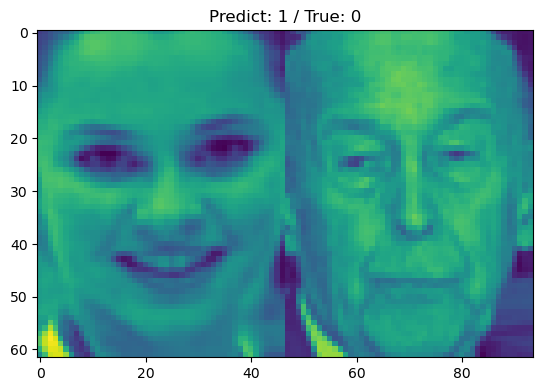

In [57]:
def false_predict(i):
    X = test_data['data'][i]
    X = X.reshape(2, 62, 47)
    X = np.concatenate((X[0, :], X[1, :]), axis=1)
    X = X * 255
    plt.title(f'Predict: {pred[i]} / True: {test_data['target'][i]}')
    plt.imshow(X)
    plt.show()

false_predict(986)

In [8]:
train = data['data']
pca = PCA(n_components=50)
train = pca.fit_transform(train)
train.shape

(2200, 50)

In [9]:
test = test_data['data']
test = pca.transform(test)
test.shape

(1000, 50)

In [ ]:
pipeline = [
    ('pca', pca),
    ('model', model)
]

In [3]:
image1 = data['data'][:, :2914]
image2 = data['data'][:, 2914:]

In [4]:
train = np.abs(image1 - image2)
train.shape

(2200, 2914)

In [ ]:
def image_augmentation4(X, y, augmentation_ratio=0.5):
    augmented_images = list(X)  # Start with original images
    augmented_labels = list(y)  # Start with original labels

    # Determine the number of images to augment based on augmentation_ratio
    total_images = len(X)
    num_augment = int(augmentation_ratio * total_images)

    for i in range(8):  # 6 augmentation types
        augment_indices = np.random.choice(total_images, size=num_augment, replace=False)
        
        for image_idx in augment_indices:
            original_image = X[image_idx]
            label = y[image_idx]
            
            # Apply specific augmentation logic
            if i == 0:  # Horizontal flip
                augmented_image = original_image.transpose(Image.FLIP_LEFT_RIGHT)
            elif i == 1:  # Brightness adjustment
                augmented_image = ImageEnhance.Brightness(original_image.convert('L')).enhance(np.random.uniform(0.7, 1.5))
            elif i == 2:  # Contrast adjustment
                augmented_image = ImageEnhance.Contrast(original_image.convert('L')).enhance(np.random.uniform(0.5, 2))
            elif i == 3:  # Sharpness adjustment
                augmented_image = ImageEnhance.Sharpness(original_image.convert('L')).enhance(np.random.uniform(0.5, 2))
            elif i == 4:  # Edge detection
                augmented_image = original_image.convert('L').filter(ImageFilter.FIND_EDGES)
            elif i == 5:  # Gaussian blur
                augmented_image = original_image.convert('L').filter(ImageFilter.GaussianBlur(np.random.uniform(0.7, 1)))
            elif i == 6:
                augmented_image = original_image.convert('L').filter(ImageFilter.EDGE_ENHANCE_MORE)
            elif i == 7:
                augmented_image = original_image.convert('L').filter(ImageFilter.CONTOUR)
                
            

            # Add augmented image and label to the dataset
            augmented_images.append(augmented_image)
            augmented_labels.append(label)
    
    # Normalize the images and convert labels to numpy arrays
    X = np.array([np.array(img) / 255 for img in augmented_images])  # Normalize images
    y = np.array(augmented_labels)
    
    return X, y


In [51]:
def numpy_to_pil(images_array):
    pil_images = []
    for i in range(images_array.shape[0]):
        img = Image.fromarray(images_array[i] * 255, mode='F')
        pil_images.append(img)
    return pil_images

def preprocessing(X_train, y_train, augmentation_ratio=0.5):
    X1, X2 = X_train[:, :X_train.shape[1]//2], X_train[:, X_train.shape[1]//2:]
    X1, X2 = numpy_to_pil(X1), numpy_to_pil(X2)
    X1, y = image_augmentation4(X1, y_train, augmentation_ratio)
    X2, _ = image_augmentation4(X2, y_train, augmentation_ratio)
    X1, X2 = X1.reshape(X1.shape[0], -1), X2.reshape(X2.shape[0], -1)
    X = np.abs(X1 - X2)
    return X, y

def preprocessing_test(X):
    X1, X2 = X[:, :X.shape[1]//2], X[:, X.shape[1]//2:]
    X = np.abs(X1 - X2)
    return X


X_train, y_train = preprocessing(data['data'], data['target'])
X_test = preprocessing_test(test_data['data'])
y_test = test_data['target']

pca = PCA(n_components=150, random_state=101)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(8800, 150) (8800,)
(1000, 150) (1000,)


In [55]:
from PIL import Image, ImageEnhance, ImageFilter
import numpy as np

def horizontal_flip(img):
    return img.transpose(Image.FLIP_LEFT_RIGHT)

def random_brightness(img, brightness_range=(0.7, 1.5)):
    img = img.convert('L')
    factor = np.random.uniform(*brightness_range)
    return ImageEnhance.Brightness(img).enhance(factor)

def random_contrast(img, contrast_range=(0.5, 2.0)):
    img = img.convert('L')
    factor = np.random.uniform(*contrast_range)
    return ImageEnhance.Contrast(img).enhance(factor)

def random_sharpness(img, sharpness_range=(0.5, 2.0)):
    img = img.convert('L')
    factor = np.random.uniform(*sharpness_range)
    return ImageEnhance.Sharpness(img).enhance(factor)

def gaussian_blur(img, blur_range=(0.7, 1.0)):
    img = img.convert('L')
    radius = np.random.uniform(*blur_range)
    return img.filter(ImageFilter.GaussianBlur(radius))

def edge_detection(img):
    img = img.convert('L')
    return img.filter(ImageFilter.FIND_EDGES)

def edge_enhance_more(img):
    img = img.convert('L')
    return img.filter(ImageFilter.EDGE_ENHANCE_MORE)

def contour_filter(img):
    img = img.convert('L')
    return img.filter(ImageFilter.CONTOUR)

# Define a list or dictionary of augmentations and their probabilities.
AUGMENTATIONS = [
    (horizontal_flip, 0.3),       # 30% chance to flip
    (random_brightness, 0.2),     # 20% chance to adjust brightness
    (random_contrast, 0.2),       # and so on...
    (random_sharpness, 0.2),
    (gaussian_blur, 0.1),
    (edge_detection, 0.05),
    (edge_enhance_more, 0.05),
    (contour_filter, 0.05),
]

def augment_image(img):
    # Decide which augmentations to apply randomly
    for aug_func, aug_prob in AUGMENTATIONS:
        if np.random.rand() < aug_prob:
            img = aug_func(img)
    return img

def image_augmentation(X, y, augmentation_ratio=0.5, max_aug_per_image=1):
    """
    A more flexible augmentation:
    - augmentation_ratio: fraction of images for which we generate augmented versions.
    - max_aug_per_image: how many augmented variants you want per original image (can be > 1).
    """
    augmented_images = []
    augmented_labels = []
    
    total_images = len(X)
    num_to_augment = int(augmentation_ratio * total_images)

    # Randomly pick images to augment
    indices_to_augment = np.random.choice(total_images, size=num_to_augment, replace=False)
    
    # Add original images
    augmented_images.extend(X)
    augmented_labels.extend(y)

    for idx in indices_to_augment:
        for _ in range(max_aug_per_image):
            aug_img = augment_image(X[idx])
            augmented_images.append(aug_img)
            augmented_labels.append(y[idx])
            
    # Convert to arrays and normalize
    X_out = np.array([np.array(img, dtype=np.float32) / 255.0 for img in augmented_images])
    y_out = np.array(augmented_labels)
    return X_out, y_out

def numpy_to_pil(images_array):
    pil_images = []
    for i in range(images_array.shape[0]):
        img = Image.fromarray((images_array[i] * 255).astype('float32'), mode='F')
        pil_images.append(img)
    return pil_images

def preprocessing(X_train, y_train, augmentation_ratio=0.5):
    half = X_train.shape[1] // 2
    X1, X2 = X_train[:, :half], X_train[:, half:]
    X1, X2 = numpy_to_pil(X1), numpy_to_pil(X2)

    # Apply augmentation
    X1_aug, y = image_augmentation(X1, y_train, augmentation_ratio=augmentation_ratio, max_aug_per_image=1)
    X2_aug, _ = image_augmentation(X2, y_train, augmentation_ratio=augmentation_ratio, max_aug_per_image=1)

    # Reshape to vectors and compute difference
    X1_aug = X1_aug.reshape(X1_aug.shape[0], -1)
    X2_aug = X2_aug.reshape(X2_aug.shape[0], -1)

    X = np.abs(X1_aug - X2_aug)
    return X, y

def preprocessing_test(X):
    half = X.shape[1] // 2
    X1, X2 = X[:, :half], X[:, half:]
    X = np.abs(X1 - X2)
    return X

X_train, y_train = preprocessing(data['data'], data['target'])
X_test = preprocessing_test(test_data['data'])
y_test = test_data['target']

pca = PCA(n_components=150, random_state=101)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(3300, 150) (3300,)
(1000, 150) (1000,)


In [7]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier, StackingClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier
from sklearn.ensemble import GradientBoostingClassifier

In [10]:
knn = KNeighborsClassifier(n_neighbors=5)
pred = knn.fit(X_train,y_train).predict(X_test)
print(accuracy_score(y_test, pred))

rf = RandomForestClassifier(random_state = 101)
pred = rf.fit(X_train,y_train).predict(X_test)
print(accuracy_score(y_test, pred))

svc = SVC(probability = True, kernel='rbf', random_state=101)
pred = svc.fit(X_train,y_train).predict(X_test)
print(accuracy_score(y_test, pred))

0.583
0.641
0.662


In [56]:
mlp = MLPClassifier(hidden_layer_sizes=(150, 100, 50), solver='adam', max_iter=1000, activation='relu', early_stopping=True, random_state=101)
pred = mlp.fit(X_train,y_train).predict(X_test)
print(accuracy_score(y_test, pred))

0.639


In [57]:
param_grid = {
    'hidden_layer_sizes': [(150, 100, 50)],
    'activation': ['relu'],
    'solver': ['adam'],
    'alpha': [1e-5, 1e-4, 1e-3, 1e-2],  # Regularization parameter
    'learning_rate_init': [0.001, 0.01, 0.1],
    'max_iter': [200, 500, 1000],
    'early_stopping': [True, False]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

best_mlp = RandomizedSearchCV(
    MLPClassifier(random_state=101),
    param_distributions=param_grid,
    refit=True,
    cv=cv,
    n_jobs=-1
)
best_mlp.fit(X_train, y_train)
pred = best_mlp.best_estimator_.predict(X_test)
print(f"{accuracy_score(y_test, pred)}")
print(f"{best_mlp.best_params_}")

0.588
{'solver': 'adam', 'max_iter': 1000, 'learning_rate_init': 0.01, 'hidden_layer_sizes': (150, 100, 50), 'early_stopping': False, 'alpha': 1e-05, 'activation': 'relu'}


In [39]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

param_grid = {
    'learning_rate': [1e-4, 5e-4, 1e-3, 5e-3, 1e-2],
    'n_estimators': [100, 250, 500, 750, 1000],
    'max_depth': [3, 4, 5, 6, 7],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2'],
    'loss': ['deviance', 'exponential']  # 'deviance' is equivalent to logistic regression
}
# Initialize the GradientBoostingClassifier
gbc = GradientBoostingClassifier(random_state=101)

# Initialize RandomizedSearchCV
best_gbc = RandomizedSearchCV(
    estimator=gbc,
    param_distributions=param_grid,
    n_iter=100,  # Number of parameter settings sampled
    cv=cv,
    scoring='accuracy',
    verbose=3,
    random_state=101,
    n_jobs=-1,
    return_train_score=True  # To analyze training vs. validation scores
)

# Fit the model
best_gbc.fit(X_train, y_train)

# Predict and evaluate
pred_gbc = best_gbc.best_estimator_.predict(X_test)
print("Gradient Boosting Classifier Accuracy:", accuracy_score(y_test, pred_gbc))
print("Best Parameters:", best_gbc.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 3/5] END learning_rate=0.001, loss=exponential, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000, subsample=0.6;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END learning_rate=0.001, loss=exponential, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000, subsample=0.6;, score=(train=nan, test=nan) total time=   0.0s
[CV 4/5] END learning_rate=0.001, loss=exponential, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000, subsample=0.6;, score=(train=nan, test=nan) total time=   0.0s
[CV 2/5] END learning_rate=0.001, loss=exponential, max_depth=4, max_features=auto, min_samples_leaf=4, min_samples_split=5, n_estimators=1000, subsample=0.6;, score=(train=nan, test=nan) total time=   0.0s
[CV 1/5] END learning_rate=0.0005, loss=deviance, max_depth=4, max_features=log2, min_samples_leaf=2, min_sam

/opt/miniconda3/envs/com6018/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
305 fits failed out of a total of 500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
67 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/miniconda3/envs/com6018/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/miniconda3/envs/com6018/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/opt/miniconda3/envs/com6018/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_co

Gradient Boosting Classifier Accuracy: 0.655
Best Parameters: {'subsample': 0.6, 'n_estimators': 750, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 5, 'loss': 'exponential', 'learning_rate': 0.0005}


In [40]:
param_distributions = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
    'kernel': ['rbf']
}

cv = KFold(n_splits=5, shuffle=True, random_state=101)

best_svc = RandomizedSearchCV(
    estimator=SVC(random_state=101, probability=True),
    param_distributions=param_distributions,
    n_iter=50,
    cv=cv,
    verbose=3,
    scoring='accuracy',
    random_state=101,
    n_jobs=-1,
    return_train_score=True
)

best_svc.fit(X_train, y_train)
pred = best_svc.best_estimator_.predict(X_test)
print(accuracy_score(y_test, pred))
print(best_svc.best_params_)

/opt/miniconda3/envs/com6018/lib/python3.12/site-packages/sklearn/model_selection/_search.py:320: UserWarning: The total space of parameters 20 is smaller than n_iter=50. Running 20 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 1/5] END C=0.1, gamma=0.1, kernel=rbf;, score=(train=0.759, test=0.639) total time=   4.3s
[CV 2/5] END C=0.1, gamma=0.1, kernel=rbf;, score=(train=0.553, test=0.527) total time=   4.3s
[CV 1/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.503, test=0.486) total time=   4.3s
[CV 4/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.503, test=0.489) total time=   4.4s
[CV 5/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.501, test=0.495) total time=   4.4s
[CV 3/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.503, test=0.489) total time=   4.3s
[CV 2/5] END C=0.1, gamma=1, kernel=rbf;, score=(train=0.502, test=0.491) total time=   4.5s
[CV 3/5] END C=0.1, gamma=0.1, kernel=rbf;, score=(train=0.641, test=0.607) total time=   4.6s
[CV 3/5] END C=0.1, gamma=0.01, kernel=rbf;, score=(train=0.661, test=0.618) total time=   4.2s
[CV 2/5] END C=0.1, gamma=0.01, kernel=rbf;, score=(train=0.670, test=0.630) total time=   4

In [43]:
estimators = [('mlp', best_mlp.best_estimator_), ('svc',best_svc.best_estimator_)]

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=101)

stacking_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=cv,
    n_jobs=-1,
    verbose=5
)

pred = stacking_clf.fit(X_train,y_train).predict(X_test)
print(accuracy_score(y_test, pred))

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    1.1s remaining:    1.7s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    1.3s finished
[Parallel(n_jobs=-1)]: Done   2 out of   5 | elapsed:    3.1s remaining:    4.6s
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:    3.1s finished


0.67


In [58]:
result = {}
for i in range(2,8):
    predictions = []
    i = i / 10
    X_train, y_train = preprocessing(data['data'], data['target'], i)
    X_test = preprocessing_test(test_data['data'])
    y_test = test_data['target']

    pca = PCA(n_components=150, random_state=101)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)
    
    svc = SVC(probability = True)
    pred = svc.fit(X_train,y_train).predict(X_test)
    predictions.append(accuracy_score(y_test, pred))
    
    mlp = MLPClassifier(hidden_layer_sizes=(128, 64), solver='adam', max_iter=1000, activation='relu', early_stopping=True, random_state=101)
    pred = mlp.fit(X_train,y_train).predict(X_test)
    predictions.append(accuracy_score(y_test, pred))
    
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.01, max_depth=3, random_state=101)
    pred = gbc.fit(X_train,y_train).predict(X_test)
    predictions.append(accuracy_score(y_test, pred))
    
    # cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=101)

    # estimators = [('mlp', mlp), ('svc',svc), ('gbc', gbc)]#, ('voting_soft', voting_clf_soft)]

    # stacking_clf = StackingClassifier(
    #     estimators=estimators,
    #     final_estimator=LogisticRegression(),
    #     cv=cv,
    #     n_jobs=-1
    # )
    # pred = stacking_clf.fit(X_train,y_train).predict(X_test)
    # predictions.append(accuracy_score(y_test, pred))
    
    print(f'At Ratio {i}: {predictions}')
    
    result[i] = predictions

At Ratio 0.2: [0.651, 0.652, 0.672]
At Ratio 0.3: [0.651, 0.625, 0.647]
At Ratio 0.4: [0.647, 0.618, 0.65]
At Ratio 0.5: [0.652, 0.599, 0.629]
At Ratio 0.6: [0.644, 0.635, 0.647]
At Ratio 0.7: [0.661, 0.629, 0.642]


In [ ]:
# 0 - 4
result